In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from utils.preprocessing_text import Preprocess
from sklearn.model_selection import train_test_split

from utils.util import create_folder
from utils.util import plot_bar_chart


label_names = ['Algebra', 'Combinatorics', 'Geometry', ' Number Theory']
df = pd.read_csv("../data/classification/imo.csv")
df['post_canonical'] = df['post_rendered'].apply(Preprocess().fit)

def string_to_txt(path, file_name, string):
    if not file_name.endswith('.txt'):
        file_name += '.txt'
        
    file_path = f"{path}/{file_name}"

    with open(file_path, 'w') as file:
        file.write(string)

def prepare_dataset(df, random_state=42, reduce_algebra=None, reduce_combin=None, reduce_geomet=None, reduce_nt=None, truncate=False):
    shape_total = df.shape
    df = df[df['label'].notna()]
    shape_notna = df.shape
    
    print(f"Shape total: {shape_total}")
    print(f"Shape notna: {shape_notna}")
    
    algebra = df[df['label'] == 'Algebra']
    combin = df[df['label'] == 'Combinatorics']
    geomet = df[df['label'] == 'Geometry']
    nt = df[df['label'] == 'Number Theory']
    label_values = [algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]]
    sum_label_values=sum(label_values)
    
    figure, axes = plt.subplots(1, 2, figsize=(14, 4), layout="constrained")
    y_range = (0, 1450)
    
    plt.subplot(1, 2, 1)
    plot_bar_chart(label_names, label_values, 
                   title=f"DATASET DISTRIBUTION (BEFORE REDUCING={sum_label_values})",
                   x_label="Label",
                   y_label="Data",
                   y_range=y_range)
    
    # Kalau mau disamain semua
    if truncate:
        m = min([algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]])
        algebra = algebra.sample(m, random_state=random_state)
        combin = combin.sample(m, random_state=random_state)
        geomet = geomet.sample(m, random_state=random_state)
        nt = nt.sample(m, random_state=random_state)
        label_values = [algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]]
        sum_label_values=sum(label_values)

        plt.subplot(1, 2, 2)
        plot_bar_chart(label_names, label_values, 
                       title=f"DATASET DISTRIBUTION (AFTER REDUCING={sum_label_values}) USING THIS DATASET", 
                       x_label="Label",
                       y_label="Data",
                       y_range=y_range)
        
        return algebra, combin, geomet, nt
    
    if reduce_algebra is not None: algebra=algebra.sample(algebra.shape[0]-reduce_algebra, random_state=random_state)
    if reduce_combin is not None: combin=combin.sample(combin.shape[0]-reduce_combin, random_state=random_state)
    if reduce_geomet is not None: geomet=geomet.sample(geomet.shape[0]-reduce_geomet, random_state=random_state)
    if reduce_nt is not None: nt=nt.sample(nt.shape[0]-reduce_nt, random_state=random_state)
    label_values = [algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]]
    sum_label_values=sum(label_values)
    
    plt.subplot(1, 2, 2)
    plot_bar_chart(label_names, label_values, 
                   title=f"DATASET DISTRIBUTION (AFTER REDUCING={sum_label_values}) USING THIS DATASET", 
                   x_label="Label",
                   y_label="Data",
                   y_range=y_range)

    return algebra, combin, geomet, nt


c:\wamp64\www\artofproblemsolving\models\utils\preprocessing_text.py:116: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(text, 'html.parser').get_text()
c:\wamp64\www\artofproblemsolving\models\utils\preprocessing_text.py:145: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(html_text, 'html.parser')


In [2]:
def fit(truncate):
    random_state = 42
    reduce_algebra = 0
    reduce_combin = 0
    reduce_geomet = 335
    reduce_nt = 0

    algebra, combin, geomet, nt = prepare_dataset(
        df, 
        random_state=42,
        reduce_algebra=reduce_algebra, 
        reduce_combin=reduce_combin, 
        reduce_geomet=reduce_geomet, 
        reduce_nt=reduce_nt,
        truncate=truncate)

    algebra_combin_geomet_nt = [algebra, combin, geomet, nt]

    # Split train-test
    # -------------------------------------------------------------
    test_size=0.2
    val_size=0.1
    random_state=42
    __ = {
        'train': float(f"{(1-test_size) * (1-val_size):.2f}"),
        'test': float(f"{test_size:.2f}"),
        'val': float(f"{(1-test_size) * val_size:.2f}")
    }

    if truncate is False:
        train_path = "../data/classification/train"
        test_path = "../data/classification/test"
        val_path = "../data/classification/val"
    elif truncate is True:
        train_path = "../data/classification/train_truncated"
        test_path = "../data/classification/test_truncated"
        val_path = "../data/classification/val_truncated"
        
    create_folder(train_path)
    create_folder(test_path)
    create_folder(val_path)

    all_train = []
    all_test  = []
    all_val  = []
    for each in algebra_combin_geomet_nt:
        train, test = train_test_split(each, test_size=test_size, random_state=random_state)
        train, val = train_test_split(train, test_size=val_size, random_state=random_state)
        
        all_train.append(train)
        all_test.append(test)
        all_val.append(val)
        
        current_label = str(list(each['label'])[0])
        current_path_train = f"{train_path}/{current_label}"
        current_path_test = f"{test_path}/{current_label}"
        current_path_val = f"{val_path}/{current_label}"
        
        create_folder(current_path_train)
        create_folder(current_path_test)
        create_folder(current_path_val)
        
        train = train.to_dict('records')
        for i in range(len(train)):
            id_key = str(train[i]['id_key'])
            string = train[i]['post_canonical']
            string_to_txt(path=current_path_train, file_name=id_key, string=string)

        test = test.to_dict('records')
        for j in range(len(test)):
            id_key = str(test[j]['id_key'])
            string = test[j]['post_canonical']
            string_to_txt(path=current_path_test, file_name=id_key, string=string)

        val = val.to_dict('records')
        for k in range(len(val)):
            id_key = str(val[k]['id_key'])
            string = val[k]['post_canonical']
            string_to_txt(path=current_path_val, file_name=id_key, string=string)

    df_train = pd.concat([all_train[0], all_train[1], all_train[2], all_train[3]], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
    df_test = pd.concat([all_test[0], all_test[1], all_test[2], all_test[3]], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
    df_val = pd.concat([all_val[0], all_val[1], all_val[2], all_val[3]], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)

    if truncate is False:
        df_train.to_csv(f"../data/classification/train.csv", index=False)
        df_test.to_csv(f"../data/classification/test.csv", index=False)
        df_val.to_csv(f"../data/classification/val.csv", index=False)
    elif truncate is True:
        df_train.to_csv(f"../data/classification/train_truncated.csv", index=False)
        df_test.to_csv(f"../data/classification/test_truncated.csv", index=False)
        df_val.to_csv(f"../data/classification/val_truncated.csv", index=False)

    # For display distribution (below cell)
    train_values = [
        all_train[0].shape[0],
        all_train[1].shape[0],
        all_train[2].shape[0],
        all_train[3].shape[0],
    ]

    test_values = [
        all_test[0].shape[0],
        all_test[1].shape[0],
        all_test[2].shape[0],
        all_test[3].shape[0],
    ]

    val_values = [
        all_val[0].shape[0],
        all_val[1].shape[0],
        all_val[2].shape[0],
        all_val[3].shape[0],
    ]

    print(f"\n{__}")

    # Display distribution
    # -------------------------------------------------------------
    figure, ax = plt.subplots(1, 3, figsize=(14, 4), layout="constrained")
    max_y_range = max(train_values) + 55

    plt.subplot(1, 3, 1)
    plot_bar_chart(label_names, train_values, 
                title=f"DISTRIBUTION OF TRAIN DATASET ({sum(train_values)})",
                x_label="Label",
                y_label="Data",
                y_range=(0,max_y_range))

    plt.subplot(1, 3, 2)
    plot_bar_chart(label_names, test_values, 
                title=f"DISTRIBUTION OF TEST DATASET ({sum(test_values)})",
                x_label="Label",
                y_label="Data",
                y_range=(0,max_y_range))

    plt.subplot(1, 3, 3)
    plot_bar_chart(label_names, val_values, 
                title=f"DISTRIBUTION OF VAL DATASET ({sum(val_values)})",
                x_label="Label",
                y_label="Data",
                y_range=(0,max_y_range))

    print(f"Total        = {sum(train_values) + sum(test_values) + sum(val_values)}")
    print(f"test_size    = {test_size}")
    print(f"val_size     = {val_size}")
    print(f"random_state = {random_state}")

    # -------------------------------------------------------------


# Truncated

Shape total: (10968, 10)
Shape notna: (3845, 10)
Folder --> '../data/classification/train_truncated' created
Folder --> '../data/classification/test_truncated' created
Folder --> '../data/classification/val_truncated' created
Folder --> '../data/classification/train_truncated/Algebra' created
Folder --> '../data/classification/test_truncated/Algebra' created
Folder --> '../data/classification/val_truncated/Algebra' created
Folder --> '../data/classification/train_truncated/Combinatorics' created
Folder --> '../data/classification/test_truncated/Combinatorics' created
Folder --> '../data/classification/val_truncated/Combinatorics' created
Folder --> '../data/classification/train_truncated/Geometry' created
Folder --> '../data/classification/test_truncated/Geometry' created
Folder --> '../data/classification/val_truncated/Geometry' created
Folder --> '../data/classification/train_truncated/Number Theory' created
Folder --> '../data/classification/test_truncated/Number Theory' created
Fol

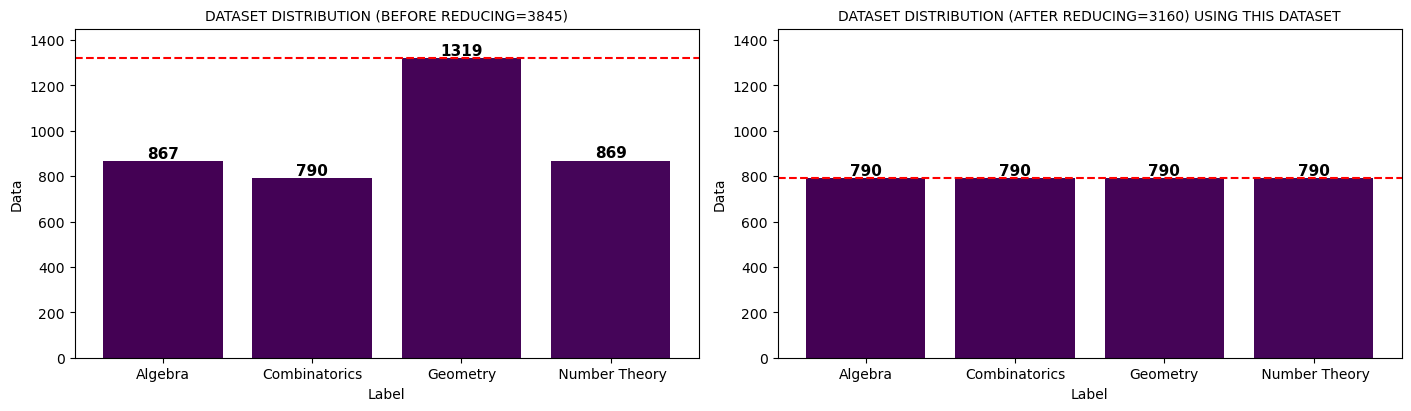

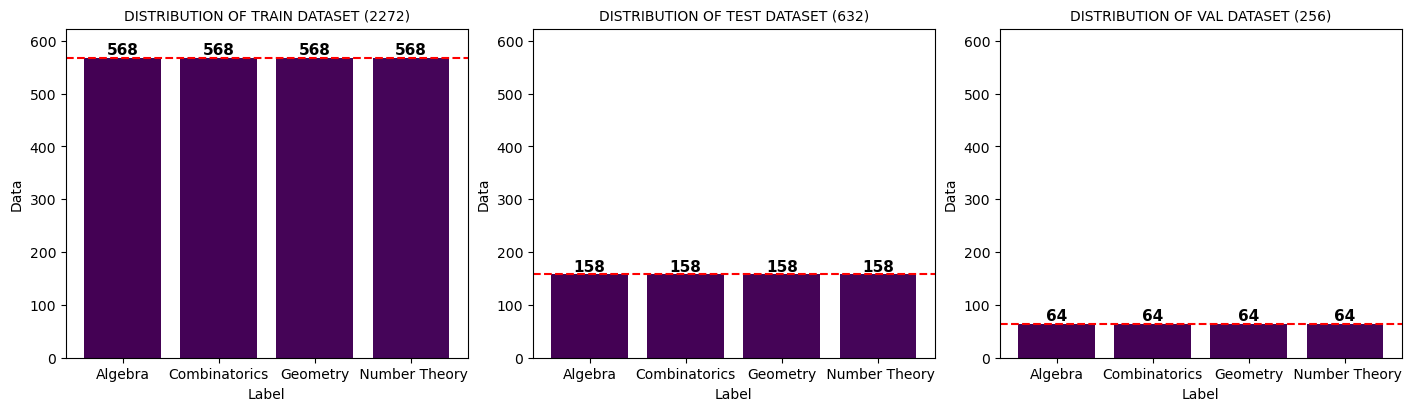

In [3]:
fit(truncate=True)

# NOT Truncated

Shape total: (10968, 10)
Shape notna: (3845, 10)
Folder --> '../data/classification/train' created
Folder --> '../data/classification/test' created
Folder --> '../data/classification/val' created
Folder --> '../data/classification/train/Algebra' created
Folder --> '../data/classification/test/Algebra' created
Folder --> '../data/classification/val/Algebra' created
Folder --> '../data/classification/train/Combinatorics' created
Folder --> '../data/classification/test/Combinatorics' created
Folder --> '../data/classification/val/Combinatorics' created
Folder --> '../data/classification/train/Geometry' created
Folder --> '../data/classification/test/Geometry' created
Folder --> '../data/classification/val/Geometry' created
Folder --> '../data/classification/train/Number Theory' created
Folder --> '../data/classification/test/Number Theory' created
Folder --> '../data/classification/val/Number Theory' created

{'train': 0.72, 'test': 0.2, 'val': 0.08}
Total        = 3510
test_size    = 0.2

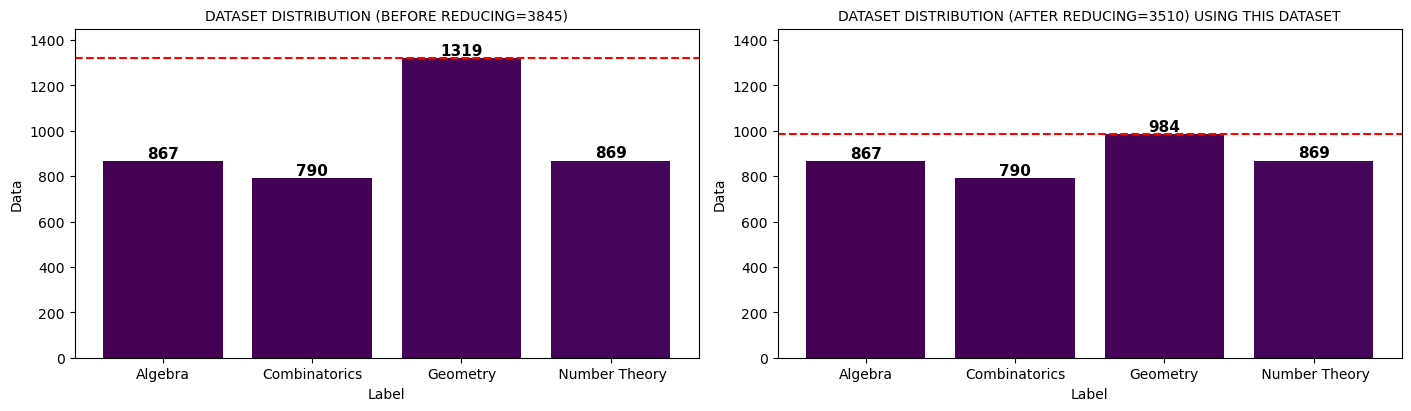

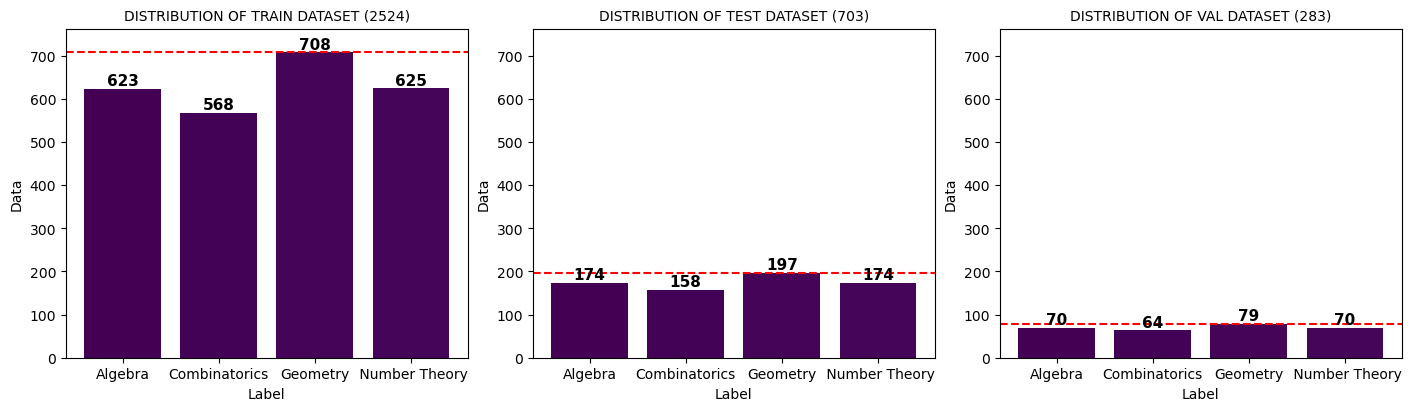

In [4]:
fit(truncate=False)

# Old (sayang dibuang)

In [ ]:
# test_size=0.2
# algebra, combin, geomet, nt = split_by_label(df, reduce_geomet=300)

# temp1=[algebra.shape[0], combin.shape[0], geomet.shape[0], nt.shape[0]]
# temp2=[round(temp1[0]*(1-test_size)), round(temp1[1]*(1-test_size)), round(temp1[2]*(1-test_size)), round(temp1[3]*(1-test_size))]
# temp3=[round(temp1[0]*test_size), round(temp1[1]*test_size), round(temp1[2]*test_size), round(temp1[3]*test_size)]
# print(f"               {'n':>7s} {'train':>7s} {'test':>7s}")
# print(f"Algebra       :{str(temp1[0]):>7s} {str(temp2[0]):>7s} {str(temp3[0]):>7s}")
# print(f"Combinatorics :{str(temp1[1]):>7s} {str(temp2[1]):>7s} {str(temp3[1]):>7s}")
# print(f"Geometry      :{str(temp1[2]):>7s} {str(temp2[2]):>7s} {str(temp3[2]):>7s}")
# print(f"NT            :{str(temp1[3]):>7s} {str(temp2[3]):>7s} {str(temp3[3]):>7s}")
# print("_________________________________________+")
# print(f"Total         :{str(sum(temp1)):>7s} {str(sum(temp2)):>7s} {str(sum(temp3)):>7s}")


                     n   train    test
Algebra       :    815     652     163
Combinatorics :    737     590     147
Geometry      :    972     778     194
NT            :    795     636     159
_________________________________________+
Total         :   3319    2656     663
